In [15]:
from typing import Tuple
import numpy as np
import deepgp
import matplotlib.pyplot as plt
from datetime import datetime
import os

import GPy
from GPy.models import GPRegression
from emukit.test_functions import forrester_function
from emukit.core.initial_designs import RandomDesign
from emukit.core.initial_designs.latin_design import LatinDesign
from emukit.model_wrappers import GPyModelWrapper
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement, NegativeLowerConfidenceBound, ProbabilityOfImprovement, EntropySearch
from emukit.core.optimization import GradientAcquisitionOptimizer
from emukit.core.initial_designs import RandomDesign
from emukit.core import ParameterSpace, ContinuousParameter
from emukit.sensitivity.monte_carlo import MonteCarloSensitivity
from gpflow.kernels import RBF, White, Linear
from tqdm import tqdm

from simulator import MainSimulator, TinySimulator
from world import DebugInfo
from pprint import pprint

main_simulator = MainSimulator()

In [16]:
def plot_prediction(X,Y,x_plot,mu_plot,var_plot,axis):
    axis.plot(X, Y, "ro", markersize=10, label="Observations")
    axis.plot(x_plot[:, 0], mu_plot[:, 0], "C0", label="Model")
    axis.fill_between(x_plot[:, 0],
                     mu_plot[:, 0] + np.sqrt(var_plot)[:, 0],
                     mu_plot[:, 0] - np.sqrt(var_plot)[:, 0], color="C0", alpha=0.6)
    axis.fill_between(x_plot[:, 0],
                     mu_plot[:, 0] + 2 * np.sqrt(var_plot)[:, 0],
                     mu_plot[:, 0] - 2 * np.sqrt(var_plot)[:, 0], color="C0", alpha=0.4)
    axis.fill_between(x_plot[:, 0],
                     mu_plot[:, 0] + 3 * np.sqrt(var_plot)[:, 0],
                     mu_plot[:, 0] - 3 * np.sqrt(var_plot)[:, 0], color="C0", alpha=0.2)
    axis.legend(loc=2, prop={'size': 10})
    axis.set(xlabel=r"$x$", ylabel=r"$f(x)$")
    axis.grid(True)

In [166]:
def plot_acquisition_functions(x_plot, ac_plot, x_new, axis):
    values = ac_plot[1] if (np.max(ac_plot[1]) - np.min(ac_plot[1]) == 0) else (ac_plot[1] - np.min(ac_plot[1])) / (np.max(ac_plot[1]) - np.min(ac_plot[1]))
    axis.plot(x_plot, values, label=ac_plot[0])
    #axis.plot(x_plot, (ac_plots[0][1] - np.min(ac_plots[0][1])) / (np.max(ac_plots[0][1]) - np.min(ac_plots[0][1])), label=ac_plots[0][0])
    #axis.plot(x_plot, (ac_plots[1][1] - np.min(ac_plots[1][1])) / (np.max(ac_plots[1][1]) - np.min(ac_plots[1][1])), label=ac_plots[1][0])
    #axis.plot(x_plot, (ac_plots[2][1] - np.min(ac_plots[2][1])) / (np.max(ac_plots[2][1]) - np.min(ac_plots[2][1])), label=ac_plots[2][0])
    #axis.plot(x_plot, (ac_plots[3][1] - np.min(ac_plots[3][1])) / (np.max(ac_plots[3][1]) - np.min(ac_plots[3][1])), label=ac_plots[3][0])

    axis.axvline(x_new, color="red", label="x_next", linestyle="--")
    axis.legend(loc=1, prop={'size': 10})
    axis.set(xlabel=r"$x$", ylabel=r"$f(x)$")
    axis.grid(True)

In [18]:
import statistics

def target_function_list(X, repetition=1):
    Y = []
    for x in X:
        mutation_rates = {
            "size": x[0],
            "speed": x[1],
            "vision": x[2],
            "aggression": x[3]
        }
        # items = []
        total = 0
        for i in range(repetition):
            days_survived, log = main_simulator.run(mutation_rates, debug_info=DebugInfo(
                period=10, should_display_day=False, should_display_grid=False, should_display_traits=False), max_days=10000)
            #items.append(days_survived)
            total += days_survived
        #Y.append(statistics.median(items))
        Y.append(total//repetition)
    return np.array(Y)[:,np.newaxis]

In [19]:
# Generate the initial points to start the training process

def experiment_initialisation(space, num_data_points = 5):
    design = LatinDesign(space) # Collect random points
    X = design.get_samples(num_data_points)
    Y = target_function_list(X)
    return X, Y

In [139]:
def model_generation(X, Y, space, kernel = None):
    if kernel is None:
        kernel_rbf_1 = GPy.kern.RBF(input_dim=1, lengthscale=0.1, variance=100, active_dims=[0])
        kernel_rbf_2 = GPy.kern.RBF(input_dim=1, lengthscale=0.1, variance=100, active_dims=[1])
        kernel_rbf_3 = GPy.kern.RBF(input_dim=1, lengthscale=0.1, variance=100, active_dims=[2])
        kernel_rbf_4 = GPy.kern.RBF(input_dim=1, lengthscale=0.1, variance=100, active_dims=[3])
        kernel = kernel_rbf_1 + kernel_rbf_2 + kernel_rbf_3 + kernel_rbf_4
    model_gpy = GPRegression(X,Y,kernel, noise_var=1) # Train and wrap the model in Emukit
    model_emukit = GPyModelWrapper(model_gpy)
    return model_emukit

In [46]:
iterations = 1000
# The other mutation rates for the projection
projection = 0
# Along which trait is the function plotted: 0-size, 1-speed, 2-vision, 3-aggression
plot = 0

# returns the mean square error history of the iterations
def train(model_emukit, X, Y, space, acquisition, iterations = 1000, plot = 0, projection = 0.1):

    file_path = 'training_logs/' + acquisition + '_plot_' + str(plot) + '_projection_' + str(projection) + '_' + str(datetime.now())
    os.makedirs(file_path)
    figure, axis = plt.subplots(1, 2, figsize=(20, 6))
    x_plot = np.linspace(0, 1, 1000)[:, None]
    x_paddings = np.linspace(projection, projection, 1000)[:, None]
    x_linear = np.linspace(0, 1, 1000)[:, None]

    history = []
    with open('dataset_test/mutation_rates.npy', 'rb') as f:
      X_test = np.load(f)
    with open('dataset_test/simulated_years_of_survival.npy', 'rb') as f:
      y_test = np.load(f)

    for j in range(plot):
        x_plot = np.append(x_paddings, x_plot, axis = 1)
    for j in range(3-plot):
        x_plot = np.append(x_plot, x_paddings, axis = 1)
    
    for i in tqdm(range(iterations)):
            
        mu_plot, var_plot = model_emukit.predict(x_plot)
        plot_prediction(X[:,plot],Y,x_linear,mu_plot,var_plot,axis[0])

        #acquisition = CrossEntropy(model_emukit,space)
        acquisition = ExpectedImprovement(model_emukit)
        #acquisition = ProbabilityOfImprovement(model_emukit)
        
        predictions, _ = model_emukit.predict(X_test)
        MSE = np.square(y_test + predictions).mean()
        history.append(MSE)
        print('MSE',MSE)
        #history.append(np.square(y_test + predictions).mean())
        
        ac_plot = ("AF", acquisition.evaluate(x_plot))
        
        optimizer = GradientAcquisitionOptimizer(space)
        x_new, _ = optimizer.optimize(acquisition)
        plot_acquisition_functions(x_linear, ac_plot, x_new[0][plot], axis[1])
        print("Next position to query:", x_new)
        #acquisition.debug(np.array(x_new))
        #y_new = target_function_list(x_new)
        y_new = -target_function_list(x_new)
        X = np.append(X, x_new, axis=0)
        Y = np.append(Y, y_new, axis=0)
        print(x_new, y_new)
        print('Prediction before set_data:', x_new, model_emukit.predict(np.array(x_new)))
        model_emukit.set_data(X, Y)
        #model_emukit.optimize()
        print('Prediction after set_data:', x_new, model_emukit.predict(np.array(x_new)))
        plt.savefig(file_path + '/' + str(i) +'.png')
        plt.clf()
        figure, axis = plt.subplots(1, 2, figsize=(20, 6))
        with open(file_path + '/history.npy', 'wb') as f:
            np.save(f, np.array(history))
    return history

In [22]:
def sensitivity_2d(X, sensitivity, x_a=0, y_a=1, projection = 0):
    results = []
    for x in X:
        point = np.array([projection, projection, projection, projection])
        point[x_a] = x[0]
        point[y_a] = x[1]
        results.append(sensitivity.compute_statistics(point)[0])
    return np.array(results)

In [ ]:
sensitivity = MonteCarloSensitivity(model = model_emukit, input_domain = space)
main_effects, total_effects, _ = sensitivity.compute_effects(num_monte_carlo_points = 10000)

In [23]:
def plot_sensitivity_2d(model_emukit, x_a=0, y_a=1, projection = 0):
    space = ParameterSpace([ContinuousParameter('size', 0, 1),
                        ContinuousParameter('speed', 0, 1),
                        ContinuousParameter('vision', 0, 1),
                        ContinuousParameter('aggression', 0, 1)])
    
    sensitivity = MonteCarloSensitivity(model = model_emukit, input_domain = space)
    main_effects, total_effects, _ = sensitivity.compute_effects(num_monte_carlo_points = 10000)
    
    x_axis = np.linspace(0, 1, 100)
    y_axis = np.linspace(0, 1, 100)
    
    X_axis,Y_axis = np.meshgrid(x_axis, y_axis)
    data = np.vstack([X_axis.ravel(), Y_axis.ravel()])
    data = np.swapaxes(data,0,-1)
    
    plt.figure(figsize=(8,6))
    plt.contourf(X_axis, Y_axis, sensitivity_2d(data, sensitivity, x_a, y_a, projection).reshape(X_axis.shape), levels=20)
    plt.colorbar()
    return main_effects, total_effects

In [83]:
space = ParameterSpace([ContinuousParameter('size', 0, 1),
                            ContinuousParameter('speed', 0, 1),
                            ContinuousParameter('vision', 0, 1),
                            ContinuousParameter('aggression', 0, 1)])
X, Y = experiment_initialisation(space,5)

In [ ]:
Y_ne = -Y
kernel_mt_1 = GPy.kern.Matern32(input_dim=1, lengthscale=0.1, variance=1000, active_dims=[0])
kernel_mt_2 = GPy.kern.Matern32(input_dim=1, lengthscale=0.1, variance=1000, active_dims=[1])
kernel_mt_3 = GPy.kern.Matern32(input_dim=1, lengthscale=0.1, variance=1000, active_dims=[2])
kernel_mt_4 = GPy.kern.Matern32(input_dim=1, lengthscale=0.1, variance=1000, active_dims=[3])
kernel = kernel_mt_1 + kernel_mt_2 + kernel_mt_3 + kernel_mt_4
model = model_generation(X, Y_ne, space, kernel)
print(model.model)
#model.optimize()
ce_acquisition = CrossEntropy(model,space)
es_history = train(model, X, Y_ne, space, 'EI', 100)


Name : GP regression
Objective : 215.81337366831613
Number of Parameters : 9
Number of Optimization Parameters : 9
Updates : True
Parameters:
  GP_regression.           |   value  |  constraints  |  priors
  sum.Mat32.variance       |  1000.0  |      +ve      |        
  sum.Mat32.lengthscale    |     0.1  |      +ve      |        
  sum.Mat32_1.variance     |  1000.0  |      +ve      |        
  sum.Mat32_1.lengthscale  |     0.1  |      +ve      |        
  sum.Mat32_2.variance     |  1000.0  |      +ve      |        
  sum.Mat32_2.lengthscale  |     0.1  |      +ve      |        
  sum.Mat32_3.variance     |  1000.0  |      +ve      |        
  sum.Mat32_3.lengthscale  |     0.1  |      +ve      |        
  Gaussian_noise.variance  |     1.0  |      +ve      |        


  0%|                                                                                                                                                   | 0/100 [00:00<?, ?it/s]

MSE 48618.46060960557
Next position to query: [[0.05769332 0.28494882 0.08469175 0.12446318]]


  1%|█▍                                                                                                                                         | 1/100 [00:29<49:12, 29.83s/it]

[[0.05769332 0.28494882 0.08469175 0.12446318]] [[-1033]]
Prediction before set_data: [[0.05769332 0.28494882 0.08469175 0.12446318]] (array([[-903.09779843]]), array([[1672.17014431]]))
Prediction after set_data: [[0.05769332 0.28494882 0.08469175 0.12446318]] (array([[-1032.9223152]]), array([[1.99940198]]))
MSE 45488.65208356822
Next position to query: [[0.29937553 0.29421149 0.09495148 0.10767415]]


  2%|██▊                                                                                                                                        | 2/100 [00:50<40:15, 24.64s/it]

[[0.29937553 0.29421149 0.09495148 0.10767415]] [[-1242]]
Prediction before set_data: [[0.29937553 0.29421149 0.09495148 0.10767415]] (array([[-1234.9347445]]), array([[30.93879314]]))
Prediction after set_data: [[0.29937553 0.29421149 0.09495148 0.10767415]] (array([[-1241.77163765]]), array([[1.96767813]]))
MSE 45929.12810574232
Next position to query: [[0.43173887 0.29686331 0.15262232 0.10334768]]


  3%|████▏                                                                                                                                      | 3/100 [01:10<36:07, 22.34s/it]

[[0.43173887 0.29686331 0.15262232 0.10334768]] [[-1361]]
Prediction before set_data: [[0.43173887 0.29686331 0.15262232 0.10334768]] (array([[-977.09322837]]), array([[1378.3546015]]))
Prediction after set_data: [[0.43173887 0.29686331 0.15262232 0.10334768]] (array([[-1360.72147459]]), array([[1.99927451]]))
MSE 57821.549939109645
Next position to query: [[0.42163734 0.28992007 0.14204243 0.11222079]]
[[0.42163734 0.28992007 0.14204243 0.11222079]] [[-649]]
Prediction before set_data: [[0.42163734 0.28992007 0.14204243 0.11222079]] (array([[-1374.52184728]]), array([[62.10968449]]))
Prediction after set_data: [[0.42163734 0.28992007 0.14204243 0.11222079]] (array([[-660.68129995]]), array([[1.98389946]]))


  4%|█████▌                                                                                                                                     | 4/100 [01:20<28:03, 17.53s/it]

MSE 151672.8972639517
Next position to query: [[0.25607843 0.31479308 0.20215044 0.08478472]]
[[0.25607843 0.31479308 0.20215044 0.08478472]] [[-1341]]
Prediction before set_data: [[0.25607843 0.31479308 0.20215044 0.08478472]] (array([[-2266.53880246]]), array([[969.79823056]]))
Prediction after set_data: [[0.25607843 0.31479308 0.20215044 0.08478472]] (array([[-1341.95436224]]), array([[1.99896887]]))


  5%|██████▉                                                                                                                                    | 5/100 [01:40<29:11, 18.44s/it]

MSE 167359.71299660165
Next position to query: [[0.47876643 0.30925095 0.04416705 0.0897843 ]]
[[0.47876643 0.30925095 0.04416705 0.0897843 ]] [[-640]]
Prediction before set_data: [[0.47876643 0.30925095 0.04416705 0.0897843 ]] (array([[-2248.23695256]]), array([[997.54623075]]))
Prediction after set_data: [[0.47876643 0.30925095 0.04416705 0.0897843 ]] (array([[-641.61219292]]), array([[1.99899755]]))


  6%|████████▎                                                                                                                                  | 6/100 [01:50<24:08, 15.41s/it]

MSE 119867.54028898393
Next position to query: [[0.04886867 0.72242885 0.17262008 0.10099535]]


In [38]:
file_path = 'training_logs/CE_plot_0_projection_0_2024-01-17 03:19:53.384504'
with open(file_path + '/history.npy', 'rb') as f:
    history = np.load(f)

In [39]:
x = np.array([i for i in range(len(history))])

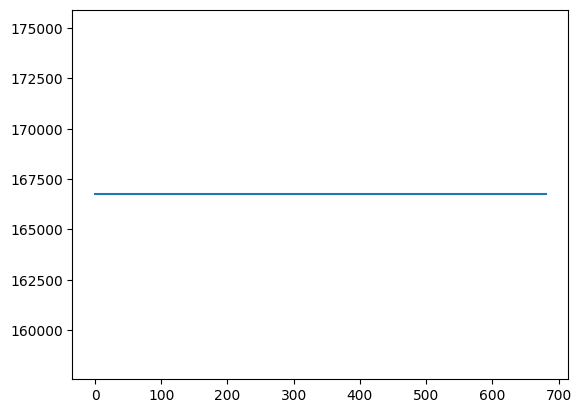

In [40]:
plt.plot(history[1:])

In [85]:
import pickle
with open(file_path+'/model.pkl', 'wb') as outp:
    pickle.dump(model, outp, pickle.HIGHEST_PROTOCOL)

In [29]:
import numpy as np
import scipy.stats
from typing import Tuple, Union
from emukit.core.acquisition import Acquisition
from emukit.core.interfaces import IDifferentiable, IJointlyDifferentiable, IModel, IModelWithNoise
from scipy.stats import entropy

class CrossEntropy(Acquisition):
    def __init__(self, model: Union[IModel, IDifferentiable],space: ParameterSpace, jitter: float = 0.0) -> None:
        """
        For a given input, this acquisition computes the improvement over the current best observed value in
        expectation. For more information see:

        Efficient Global Optimization of Expensive Black-Box Functions
        Jones, Donald R. and Schonlau, Matthias and Welch, William J.
        Journal of Global Optimization

        :param model: model that is used to compute the improvement.
        :param jitter: parameter to encourage extra exploration.
        """

        self.model = model
        self.jitter = jitter
        self.space = space

    def evaluate(self, X: np.ndarray) -> np.ndarray:
        ces = []
        for x in X:
            #print(x.shape,x)
            predicted_mu, predicted_var = self.model.predict(np.array([x]))
            predicted_mu = predicted_mu[0]
            predicted_var = predicted_var[0]

            index = np.sqrt(np.sum((self.model.X-x)**2,axis=-1)).argsort()[:5]
            observed_mu = (self.model.Y[index]*1).mean()
            observed_x2 = (self.model.Y[index]**2).mean()
                                  
            #observed_mu = (np.sqrt(np.sum((self.model.X-x)**2,axis=-1))/(np.sqrt(np.sum((self.model.X-x)**2,axis=-1))).sum()).dot(self.model.Y)
            #observed_x2 = (np.sqrt(np.sum((self.model.X-x)**2,axis=-1))/(np.sqrt(np.sum((self.model.X-x)**2,axis=-1))).sum()).dot(self.model.Y**2)
            observed_std = np.sqrt(observed_x2-observed_mu**2)
            predicted_std = np.sqrt(predicted_var)
            # print(predicted_mu, predicted_std, observed_mu, observed_std)
            temp = np.linspace(0, 1000, 1000)
            pk = scipy.stats.norm.pdf(temp, loc=predicted_mu, scale=predicted_std)/scipy.stats.norm.pdf(temp, loc=predicted_mu, scale=predicted_std).sum()
            qk = scipy.stats.norm.pdf(temp, loc=observed_mu, scale=observed_std)/scipy.stats.norm.pdf(temp, loc=observed_mu, scale=observed_std).sum()
            ce = entropy(pk, base=2) + entropy(pk, qk, base=2)
            ces.append([ce])
        return np.array(ces)

    def debug(self, X: np.ndarray) -> np.ndarray:
        ces = []
        for x in X:
            #print(x.shape,x)
            predicted_mu, predicted_var = self.model.predict(np.array([x]))
            predicted_mu = predicted_mu[0]
            predicted_var = predicted_var[0]

            index = np.sqrt(np.sum((self.model.X-x)**2,axis=-1)).argsort()[:5]
            observed_mu = (self.model.Y[index]*1).mean()
            observed_x2 = (self.model.Y[index]**2).mean()
                                  
            #inverse_distances = 1/np.sqrt(np.sum((self.model.X-x)**2,axis=-1))
            #observed_mu = (inverse_distances/inverse_distances.sum()).dot(self.model.Y)
            #observed_x2 = (inverse_distances/inverse_distances.sum()).dot(self.model.Y**2)
            
            observed_std = np.sqrt(observed_x2-observed_mu**2)
            predicted_std = np.sqrt(predicted_var)
            print(predicted_mu, predicted_std, observed_mu, observed_std)
            #print(x,predicted_mu, predicted_var)
            temp = np.linspace(0, 1000, 1000)
            pk = scipy.stats.norm.pdf(temp, loc=predicted_mu, scale=predicted_std)/scipy.stats.norm.pdf(temp, loc=predicted_mu, scale=predicted_std).sum()
            qk = scipy.stats.norm.pdf(temp, loc=observed_mu, scale=observed_std)/scipy.stats.norm.pdf(temp, loc=observed_mu, scale=observed_std).sum()
            ce = entropy(pk, base=2) + entropy(pk, qk, base=2)
            ces.append([ce])
        return np.array(ces)


    @property
    def has_gradients(self) -> bool:
        """Returns that this acquisition has gradients"""
        return False

    def _get_model_predictions(self, x: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """Get model predictions for the function values at given input locations."""
        return self.model.predict(x)

    def _get_y_minimum(self) -> np.ndarray:
        """Return the minimum value in the samples observed so far."""
        return np.min(self.model.Y, axis=0)


In [66]:
plot = 0
projection = 0.1
x_plot = np.linspace(0, 1, 1000)[:, None]
x_paddings = np.linspace(projection, projection, 1000)[:, None]
for j in range(plot):
    x_plot = np.append(x_paddings, x_plot, axis = 1)
for j in range(3-plot):
    x_plot = np.append(x_plot, x_paddings, axis = 1)
model.predict(x_plot)

(array([[-580.28643851],
        [-580.28643851],
        [-580.28643851],
        [-580.28643851],
        [-580.28643851],
        [-580.28643851],
        [-580.28643851],
        [-580.28643851],
        [-580.28643851],
        [-580.28643851],
        [-580.28643851],
        [-580.28643851],
        [-580.28643851],
        [-580.28643851],
        [-580.28643851],
        [-580.28643851],
        [-580.28643851],
        [-580.28643851],
        [-580.28643851],
        [-580.28643851],
        [-580.28643851],
        [-580.28643851],
        [-580.28643851],
        [-580.28643851],
        [-580.28643851],
        [-580.28643851],
        [-580.28643851],
        [-580.28643851],
        [-580.28643851],
        [-580.28643851],
        [-580.28643851],
        [-580.28643851],
        [-580.28643851],
        [-580.28643851],
        [-580.28643851],
        [-580.28643851],
        [-580.28643851],
        [-580.28643851],
        [-580.28643851],
        [-580.28643851],


In [63]:
model.predict(np.array([[0.1,0.1,0.1,0.1]]))

(array([[-725.54592244]]), array([[114859.86241311]]))

In [68]:
x_plot[100]

array([0.1001001, 0.1      , 0.1      , 0.1      ])

In [77]:
model.predict(np.array([[0.10000, 0.1      , 0.1      , 0.1      ]]))

(array([[-725.54592244]]), array([[114859.86241311]]))

In [85]:
kernel = GPy.kern.Matern32(input_dim=4, lengthscale=0.1, variance=100)
model = model_generation(X, Y_ne, space, kernel)
print(kernel)

  Mat32.       |  value  |  constraints  |  priors
  variance     |  100.0  |      +ve      |        
  lengthscale  |    0.1  |      +ve      |        



Name : GP regression
Objective : 526.1837714979774
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |   value  |  constraints  |  priors
  Mat32.variance           |  1000.0  |      +ve      |        
  Mat32.lengthscale        |     0.1  |      +ve      |        
  Gaussian_noise.variance  |     1.0  |      +ve      |        


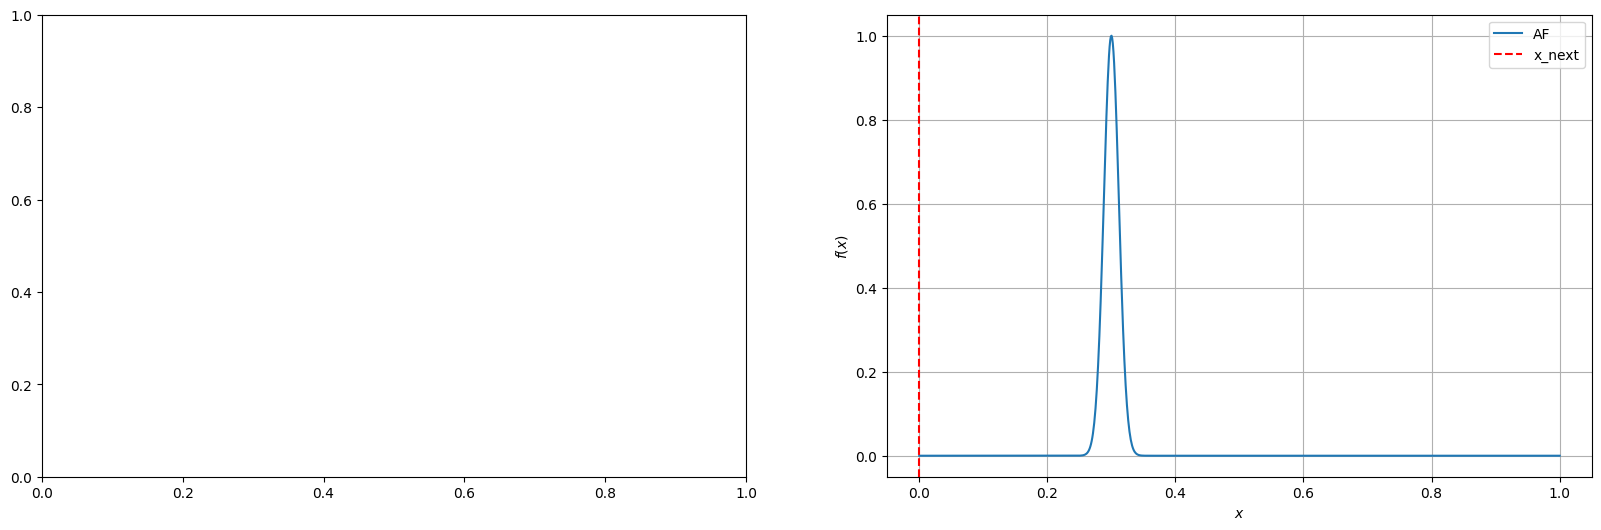

In [169]:
test_x = np.array([[0.7, 0.9, 0.3, 0.3],
       [0.3, 0.3, 0.1, 0.1],
       [0.9, 0.1, 0.5, 0.9],
       [0.5, 0.7, 0.7, 0.7],
       [0.1, 0.5, 0.9, 0.5]])
test_y = np.array([[-96],[-1000],[-12],[-12],[-12]])
kernel = GPy.kern.Matern32(input_dim=4, lengthscale=0.1, variance=1000)
model = model_generation(test_x, test_y, space, kernel)
print(model.model)
figure, axis = plt.subplots(1, 2, figsize=(20, 6))
plot = 1
projection = 0.1
acquisition = ProbabilityOfImprovement(model)
x_plot = np.linspace(0, 1, 1000)[:, None]
x_paddings = np.linspace(projection, projection, 1000)[:, None]
x_linear = np.linspace(0, 1, 1000)[:, None]

for j in range(plot):
    x_plot = np.append(x_paddings, x_plot, axis = 1)
for j in range(3-plot):
    x_plot = np.append(x_plot, x_paddings, axis = 1)
    
ac_plot = ("AF", acquisition.evaluate(x_plot))
plot_acquisition_functions(x_linear, ac_plot, 0, axis[1])

In [151]:
Y

array([[  96],
       [1234],
       [  50],
       [  50],
       [  50]])

In [136]:
ac_plot[1]

array([[0.99826301],
       [0.99821976],
       [0.99817505],
       [0.9981288 ],
       [0.99808096],
       [0.99803146],
       [0.99798024],
       [0.99792723],
       [0.99787236],
       [0.99781556],
       [0.99775674],
       [0.99769582],
       [0.99763273],
       [0.99756737],
       [0.99749965],
       [0.99742947],
       [0.99735674],
       [0.99728134],
       [0.99720317],
       [0.99712211],
       [0.99703805],
       [0.99695085],
       [0.99686039],
       [0.99676653],
       [0.99666913],
       [0.99656804],
       [0.9964631 ],
       [0.99635416],
       [0.99624103],
       [0.99612355],
       [0.99600153],
       [0.99587477],
       [0.99574308],
       [0.99560623],
       [0.99546402],
       [0.99531621],
       [0.99516255],
       [0.9950028 ],
       [0.99483669],
       [0.99466395],
       [0.99448429],
       [0.9942974 ],
       [0.99410299],
       [0.99390071],
       [0.99369022],
       [0.99347118],
       [0.9932432 ],
       [0.993

In [112]:
values = 0 if (np.max(ac_plot[1]) - np.min(ac_plot[1]) == 0) else (ac_plot[1] - np.min(ac_plot[1])) / (np.max(ac_plot[1]) - np.min(ac_plot[1]))